[<img src="../../header.svg">](../index.ipynb)

---
# Finite Elements: Error analysis for the Poisson equation
The previous section [vorherigen Beispiel](./tutorial-fem-01.ipynb) introduced the key steps for discretizing the Poisson equation. 
We revisit this equation
$$\nabla \cdot[-D \nabla u] = f $$
with diffusion constant $D$ and source $f$ with different geometries in closer detail. The goal is to determine the discretization error. 



In [1]:

import sys
sys.path.append("..")

import modsimtools as util

import ug4py.pyugcore as ug4
import ug4py.pyconvectiondiffusion as cd
# import ug4py.pysuperlu as slu

import math  # For sqrt, sin, exp, ...

## Problemdefinitionen

Die Problemdefinitionen legen wir in Form von Klassen ab:
### Problem 1

Die folgende Klasse kodiert das [vorherige Beispiel](./tutorial-fem-01.ipynb) zur Laplace-Gleichung ($D=1$). Dabei wird die rechte Seite $f$ wird so gesetzt, dass sich Sinusschwingung 

$$u(x,y) = \sin (\mu  \pi x) \sin (\nu  \pi y)$$

als Lösung ergibt. Außerdem diskretisieren wir das Einheitsquadrat mit Vierecken:

In [2]:
class SquareConfig:
    # Geometrie
    gridName= "grids/unit_square_tri.ugx" # "grids/unit_square_tri.ugx",
    requiredSubsets = {"Inner", "Boundary"}
    numRefs= 2
    
    # Constructor
    def __init__(self, mu, nu):
        self.mu = mu
        self.nu = nu
        
        self.elemDisc = cd.ConvectionDiffusionFE2d("u", "Inner")
        self.elemDisc.set_diffusion(1.0)
        self.elemDisc.set_source(lambda x,y,t : self.SourceCallback(x,y,t))
        
        self.dirichletBND = ug4.DirichletBoundary2dCPU1()
        self.dirichletBND.add(0.0, "u", "Boundary")
        
    
    # API function
    def CreateDomainDisc(self,approxSpace):   
        domainDisc = ug4.DomainDiscretization2dCPU1(approxSpace)  
        domainDisc.add(self.elemDisc)
        domainDisc.add(self.dirichletBND)
        return domainDisc
    
    
    # Callback fuer rechte Seite
    def SourceCallback(self, x, y, t):
        mu = self.mu
        nu = self.nu
        scale =  (mu*mu + nu*nu)*(math.pi)*(math.pi)
        return scale*math.sin(math.pi*mu*x)* math.sin(math.pi*nu*y)

    def SolutionCallback(self,x,y,t):
        return math.sin(math.pi*self.mu*x)* math.sin(self.math.pi*self.nu*y)


### Problem 2

In [3]:
# Callback function boundary values.
def SectorDirichletSol(x, y, t, si):
    r = math.sqrt(x*x+y*y);
    phi = math.atan2(y,x);
    if (phi<0) : phi = phi + 2*math.pi; 
    val=math.pow(r,(2/3))*math.sin(phi/3.0*2);
    return val

In [4]:
class SectorProblem:
    # Geometrie
    gridName= "grids/sectorTest.ugx"
    requiredSubsets = {"Inner", "Circle", "Cut"}
    numRefs= 4
    
    # Constructor
    def __init__(self):
        self.mu = 1.0
        self.nu = 4.0
        
        self.elemDisc = cd.ConvectionDiffusionFE2d("u", "Inner")
        self.elemDisc.set_diffusion(1.0)
        self.elemDisc.set_source(0.0)
    
        self.dirichletBND = ug4.DirichletBoundary2dCPU1()
        self.dirichletBND.add(ug4.PythonUserNumber2d(SectorDirichletSol), "u", "Circle")
        self.dirichletBND.add(0.0, "u", "Cut")
        
    # Randbedingungen
    def MyDirichletBndCallback1(x, y, t):
        if (y==1) : return True, 0.0 
        elif (y==0) : return True, math.sin(math.pi*1*x)
        else : return False, 0.0 
    
    # API function
    def CreateDomainDisc(self,approxSpace):   
        domainDisc = ug4.DomainDiscretization2dCPU1(approxSpace)  
        domainDisc.add(self.elemDisc)
        domainDisc.add(self.dirichletBND)
        return domainDisc
    
    # Solution
    def SolutionCallback(self,x,y,t,si):
        return SectorDirichletSol(x,y,t,si)
    
   

### Auswahl einer Konfiguration
Aus den o.g. Konfigurationen wählen wir eine aus:

In [5]:
#CONFIG = SquareConfig(1,4)
CONFIG = SectorProblem()

## Konfiguration von UG4

Die folgenden Schritte sind aus dem [vorherigen Beispiel](./tutorial-fem-01.ipynb) bekannt:


In [6]:
dom = util.CreateDomain(CONFIG.gridName, CONFIG.numRefs, CONFIG.requiredSubsets)
approxSpace = util.CreateApproximationSpace(dom, dict(fct = "u", type = "Lagrange", order = 1))
domainDisc = CONFIG.CreateDomainDisc(approxSpace)

Loading Domain {gridName}...
Domain loaded.
Refining ...
Refining step {i} ...
Refining step {i} ...
Refining step {i} ...
Refining step {i} ...
Refining done
Approximation space:
| ---------------------------------------------------------------------------- |
|  Number of DoFs (All Procs)                                                  |
|  Algebra: Block 1 (divide by 1 for #Index)                                   |
|                                                                              |
|    GridLevel   |       Domain |     0: Inner |    1: Circle |       2: Cut   |
| ---------------------------------------------------------------------------- |
| (lev,    0)    |           30 |            8 |           19 |            3 |
| (lev,    1)    |           95 |           51 |           37 |            7 |
| (lev,    2)    |          333 |          245 |           73 |           15 |
| (lev,    3)    |         1241 |         1065 |          145 |           31 |
| (lev,    4)    |

### Konfiguration eines iterativen Lösers

Ein Mehrgitterverfahren hat lediglich lineare Komplexität

### Assembliere und löse LGS


In [7]:
Ah = ug4.AssembledLinearOperatorCPU1(domainDisc)
uh = ug4.GridFunction2dCPU1(approxSpace)
bh = ug4.GridFunction2dCPU1(approxSpace)


import traceback
try:
    domainDisc.assemble_linear(Ah, bh)
    domainDisc.adjust_solution(uh)
except Exception as inst:
    traceback.print_exc()
    print(str(inst))
    

In [8]:
# solver = ug4.LUCPU1()
sys.path.append("..")
import util.solver_util as util_solver

gmg = util_solver.CreateMultigridPrecond(approxSpace, domainDisc, "V",2,2)
gmg.set_discretization(domainDisc)

solver = ug4.LinearSolverCPU1()
solver.set_preconditioner(gmg)
solver.set_convergence_check(util_solver.convCheck)

In [9]:

try:
    solver.init(Ah, uh)
    solver.apply(uh, bh)
except Exception as inst:
    print(inst)
    


   % %%%%%%%%      Iterative Linear Solver      %%%%%%%%%%%
   % %%%%%%%%   (Precond: Geometric MultiGrid)  %%%%%%%%%%%
   %   Iter      Defect         Rate 
   %    0:    6.299045e+00      -------
   %    1:    5.832829e-01    9.259862e-02
   %    2:    5.530197e-02    9.481158e-02
   %    3:    5.540196e-03    1.001808e-01
   %    4:    5.782232e-04    1.043687e-01
   %    5:    6.222938e-05    1.076217e-01
   %    6:    6.863544e-06    1.102943e-01
   %    7:    7.746735e-07    1.128679e-01
   %    8:    8.977517e-08    1.158878e-01
   %    9:    1.076480e-08    1.199084e-01
   %   10:    1.348940e-09    1.253104e-01
   %   11:    1.779919e-10    1.319494e-01
   %   12:    2.473423e-11    1.389627e-01
   %   13:    3.591142e-12    1.451892e-01
   % Relative reduction 1.000000e-12 reached after 13 steps.
   % Average reduction over 13 steps: 1.143275e-01
   % %%%%%  Iteration converged  %%%%%



In [10]:
import pyvista
pyvista.start_xvfb()
pyvista.set_jupyter_backend('trame')

ug4.WriteGridFunctionToVTK(uh, "fem02_solution_u")
result = pyvista.read("fem02_solution_u.vtu")
result.plot(scalars="u", show_edges=True, cmap='jet')

Widget(value='<iframe src="http://localhost:50623/index.html?ui=P_0x14ba238f0_0&reconnect=auto" class="pyvista…

## Fehleranalyse

Falls die  Lösung analytisch bekannt ist, können wir den Diskretisierungsfehler der numerischen Lösung $u_h$ bestimmen.  

Dies geschieht in der L2-Norm: $$\|u-u_h\|_0 := \sqrt{\int_\Omega (u-u_h)^2 }$$

In [11]:
err0=ug4.L2Error(ug4.PythonUserNumber2d(CONFIG.SolutionCallback), uh, "u", 1.0, 4)
print(err0)

0.000824758731386492


 Alternativ kann die H1-Norm verwendet werden, welche auch Ableitungen berücksichtigt: $$\|u-u_h\|_1 := \sqrt{\int_\Omega (u-u_h)^2+ (\nabla (u-u_h))^2 }$$


In [12]:
uref = uh.clone()
ug4.Interpolate(ug4.PythonUserNumber2d(CONFIG.SolutionCallback), uref, "u")
err1=ug4.H1Error(uref, "u",  uh, "u", 2, "Inner")
print(err1)


IntegrateSubsets for subsets=Inner
0.009078540585607878


In [13]:
errh = uh.clone()
ug4.VecScaleAdd2(errh, 1.0, uh, -1.0, uref)
ug4.WriteGridFunctionToVTK(errh, "tmp/fem02_error")
result = pyvista.read("tmp/fem02_error.vtu")
result.plot(scalars="u", show_edges=True, cmap='jet')

Widget(value='<iframe src="http://localhost:50623/index.html?ui=P_0x1041f4e60_1&reconnect=auto" class="pyvista…

Die Werte speichern wir in einer Tabelle:

In [14]:
import numpy as np
esquare=np.array([
    # numRefs, err0, err1
    [3, 0.026669178876216,0.036854207999089 ],
    [4, 0.0067063542743748,0.0096692527695234],
    [5, 0.0016790153921112,0.0024457630567399],
    [6, 0.00041990545869718,0.00061321594052763],
    [7, 0.0001049859512669,0.0001534133061914],
])


In [15]:
esector=np.array([
    # numRefs, err0, err1
    [3, 0.0021517562195368, 0.014347178579376 ],
    [4, 0.00082670975412983, 0.0090798283058054],
    [5, 0.00032006823581697, 0.0057306863871163],
    [6, 0.00013039000095758, 0.003629782236302],
    [7, 5.5487900630332e-05, 0.0022953491311963],
])


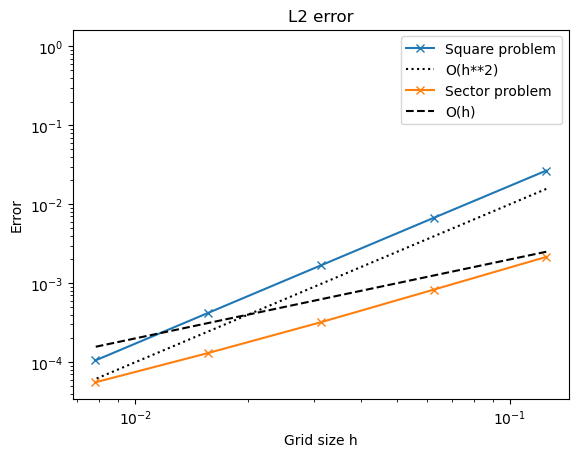

In [11]:


import matplotlib.pyplot as pyplot
pyplot.title("L2 error")
pyplot.xlabel("Grid size h")
pyplot.ylabel("Error")


pyplot.plot(0.5**(esquare[:,0]), esquare[:,1], label='Square problem', marker="x")
pyplot.plot(0.5**(esector[:,0]), (0.5**(esector[:,0]))**2, label='O(h**2)', linestyle='dotted', color='black')


pyplot.plot(0.5**(esector[:,0]), esector[:,1],  label='Sector problem', marker="x")
pyplot.plot(0.5**(esector[:,0]), 0.02*0.5**(esector[:,0]), label='O(h)', linestyle='dashed', color='black')

pyplot.legend()
pyplot.loglog(True)


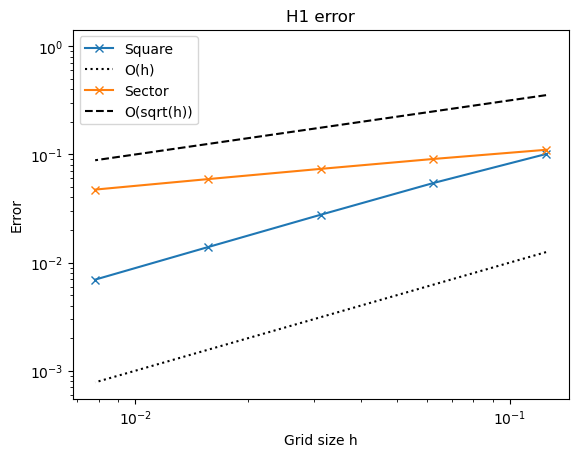

In [22]:
import matplotlib.pyplot as pyplot
pyplot.title("H1 error")
pyplot.xlabel("Grid size h")
pyplot.ylabel("Error")

h1semi_square = np.sqrt(esquare[:,2]- esquare[:,1])
h1semi_sector = np.sqrt(esector[:,2]- esector[:,1])

#pyplot.plot(0.5**(esquare[:,0]), esquare[:,2], label='Square', marker="x")
#pyplot.plot(0.5**(esector[:,0]), esector[:,2], label='Sector', marker="x")
pyplot.plot(0.5**(esector[:,0]), h1semi_square, label='Square', marker="x")
pyplot.plot(0.5**(esector[:,0]), 0.1*0.5**(esector[:,0]), label='O(h)', linestyle='dotted', color='black')

pyplot.plot(0.5**(esector[:,0]), h1semi_sector, label='Sector', marker="x")
pyplot.plot(0.5**(esector[:,0]), (0.5**(esector[:,0]))**0.5, label='O(sqrt(h))', linestyle='dashed', color='black')


pyplot.legend()
pyplot.loglog(True)